# Wolf Whistle Template Matching Notebook

One notebook for:
1) Computing cosine-similarity template matches and saving a CSV.  
2) Plotting similarity over time and a target spectrogram with match spans.  
3) Rendering a stacked spectrogram: template + top-3 matches.  
4) Exporting audio snippets and playing them inline with a summary table.

Edit paths in the **Parameters** cell. All sections reuse shared utilities.

In [ ]:
import os, numpy as np, pandas as pd, soundfile as sf, matplotlib.pyplot as plt
from scipy.signal import stft, resample_poly, medfilt, find_peaks
from IPython.display import Audio, display

TEMPLATE_PATH = "../data/raw/blue_bird_repetoire/wolf_whistle.wav"
# TEMPLATE_PATH = "../data/interim/whistle.flac"
TARGET_PATH   = "../data/interim/interesting.flac"
CSV_PATH      = "../data/processed/wolf_whistle_matches.csv"

# Analysis params
SR = 16000            # resample rate
N_FFT = 1024
HOP = 160             # 10 ms
WINDOW = 'hann'
FMIN = 300            # band-pass by zeroing bins
FMAX = 8000
SMOOTH_WIN = 5
PROMINENCE = 0.05
REL_HEIGHT = 0.0
TOP_K = 10            # for CSV
N_STACK = 5           # for stacked spectrogram
N_MATCHES_AUDIO = 5   # for audio export
CONTEXT_SEC = 0.0     # extra audio around matches when exporting

# Create processed dir if needed
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

## Utilities

In [ ]:
from math import gcd

def load_audio(path, target_sr):
    y, sr = sf.read(path, always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if sr != target_sr:
        g = gcd(sr, target_sr)
        up, down = target_sr // g, sr // g
        y = resample_poly(y, up, down)
        sr = target_sr
    return y.astype(np.float32), sr

def stft_logmag(y, sr, n_fft, hop, window, fmin=None, fmax=None):
    f, t, Z = stft(y, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=window,
                   boundary=None, padded=False)
    mag = np.abs(Z) + 1e-10
    if fmin is not None or fmax is not None:
        mask = np.ones_like(f, dtype=bool)
        if fmin is not None:
            mask &= f >= fmin
        if fmax is not None:
            mask &= f <= fmax
        mag = mag[mask, :]
        f = f[mask]
    X = np.log1p(mag)
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
    return f, t, X  # [F, T]

def frames_to_time(frames, hop, sr):
    return (np.asarray(frames) * hop) / float(sr)

def sliding_cosine(template_feat, target_feat):
    F, Tq = template_feat.shape
    F2, T  = target_feat.shape
    assert F == F2 and T >= Tq, "Feature dims must match; target must be longer"
    tvec = template_feat.reshape(-1)
    tnorm = np.linalg.norm(tvec) + 1e-8
    N = T - Tq + 1
    sim = np.empty(N, dtype=np.float32)
    chunk = 20000  # adjust for memory/speed tradeoff
    for start in range(0, N, chunk):
        end = min(N, start + chunk)
        block = np.empty((end-start, F*Tq), dtype=np.float32)
        for i, s in enumerate(range(start, end)):
            block[i] = target_feat[:, s:s+Tq].reshape(-1)
        norms = np.linalg.norm(block, axis=1) + 1e-8
        dots = block @ tvec
        sim[start:end] = dots / (norms * tnorm)
    return sim

def compute_similarity_and_peaks(yq, y):
    fq, tq, Xq = stft_logmag(yq, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    f , t , X  = stft_logmag(y , SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    if X.shape[1] < Xq.shape[1]:
        raise ValueError("Template longer than target in frames.")
    sim = sliding_cosine(Xq, X)
    sim_s = medfilt(sim, kernel_size=SMOOTH_WIN if SMOOTH_WIN%2==1 else SMOOTH_WIN+1)
    min_distance_frames = max(1, int(Xq.shape[1] * 0.5))
    peaks, props = find_peaks(sim_s, prominence=PROMINENCE, distance=min_distance_frames, rel_height=REL_HEIGHT)
    order = np.argsort(sim_s[peaks])[::-1]
    peaks = peaks[order]
    starts_sec = frames_to_time(peaks, HOP, SR)
    ends_sec   = starts_sec + (Xq.shape[1] * HOP) / float(SR)
    scores     = sim_s[peaks]
    df = pd.DataFrame({"start_s": starts_sec, "end_s": ends_sec, "similarity": scores})
    return df, sim, sim_s, (fq, tq, Xq), (f, t, X)

## 1) Run analysis and save matches CSV

Saved top-10 matches to ../data/processed/wolf_whistle_matches.csv


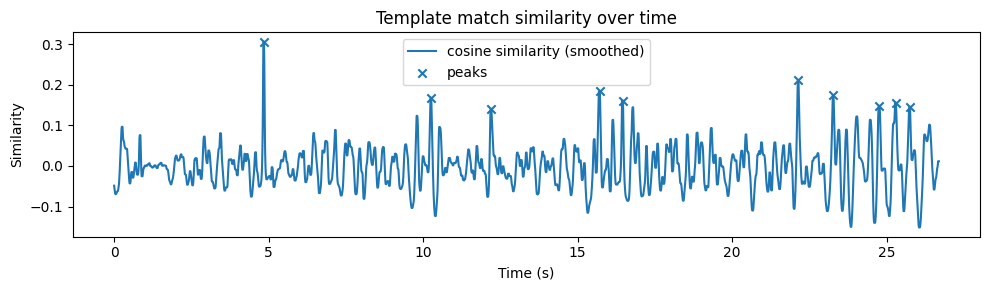

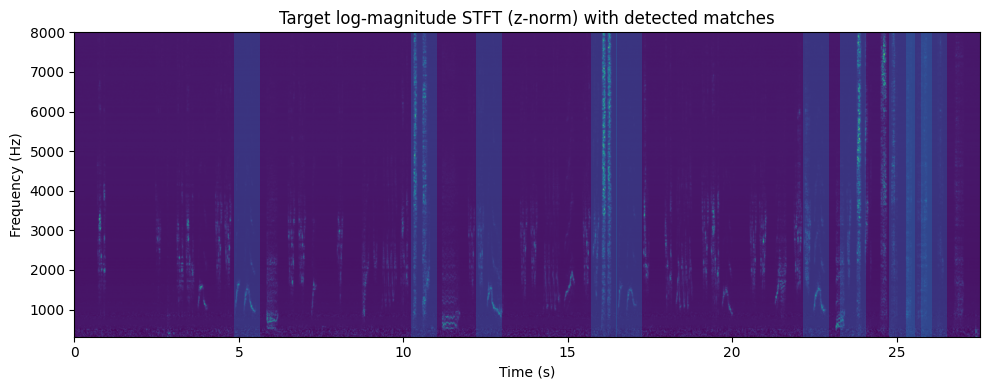

,start_s,end_s,similarity
0,4.84,5.63,0.306230
1,22.14,22.93,0.211896
2,15.71,16.50,0.183723
3,23.27,24.06,0.174695
4,10.25,11.04,0.168346
5,16.46,17.25,0.160870
6,25.29,26.08,0.155947
7,24.76,25.55,0.148191
8,25.75,26.54,0.145950
9,12.20,12.99,0.140615


In [ ]:
if not (os.path.exists(TEMPLATE_PATH) and os.path.exists(TARGET_PATH)):
    raise FileNotFoundError("Audio files not found at expected paths.")

yq, _ = load_audio(TEMPLATE_PATH, SR)
y , _ = load_audio(TARGET_PATH, SR)

# Compute matches
matches_df, sim, sim_s, (fq, tq, Xq), (f, t, X) = compute_similarity_and_peaks(yq, y)
matches_df = matches_df.sort_values("similarity", ascending=False).head(TOP_K).reset_index(drop=True)

# Save CSV
matches_df.to_csv(CSV_PATH, index=False)
print(f"Saved top-{TOP_K} matches to {CSV_PATH}")

# Plot similarity over time
plt.figure(figsize=(10, 3))
t_sim = frames_to_time(np.arange(len(sim_s)), HOP, SR)
plt.plot(t_sim, sim_s, label="cosine similarity (smoothed)")
if len(matches_df):
    plt.scatter(matches_df['start_s'].values, matches_df['similarity'].values, marker="x", label="peaks")
plt.xlabel("Time (s)")
plt.ylabel("Similarity")
plt.title("Template match similarity over time")
plt.legend()
plt.tight_layout()
plt.show()

# Plot target spectrogram with spans
plt.figure(figsize=(10, 4))
extent = (
    0.0,
    float(len(y) / SR),
    float(f[0]) if len(f) > 0 else 0.0,
    float(f[-1]) if len(f) > 0 else float(SR / 2),
)
plt.imshow(X, aspect='auto', origin='lower', extent=extent)
for s, e in zip(matches_df['start_s'].values, matches_df['end_s'].values):
    plt.axvspan(float(s), float(e), alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Target log-magnitude STFT (z-norm) with detected matches")
plt.tight_layout()
plt.show()

matches_df

## 2) Stacked spectrograms: template + top-3 matches

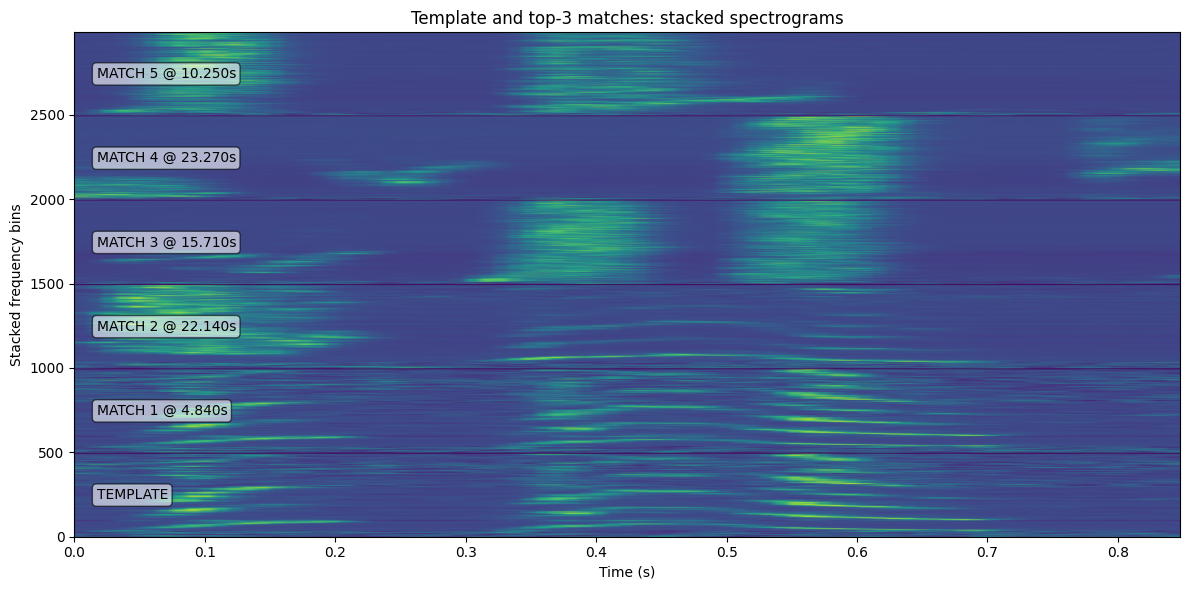

In [ ]:
if not 'matches_df' in globals():
    if os.path.exists(CSV_PATH):
        matches_df = pd.read_csv(CSV_PATH).sort_values("similarity", ascending=False)
    else:
        matches_df, sim, sim_s, (fq, tq, Xq), (f, t, X) = compute_similarity_and_peaks(yq, y)

# Top-3 starts
starts_sec = matches_df.sort_values("similarity", ascending=False).head(N_STACK)['start_s'].tolist()

# Build template spectrogram if missing
if 'Xq' not in globals():
    fq, tq, Xq = stft_logmag(yq, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)

Tq = Xq.shape[1]
template_duration = len(yq) / SR

# Extract segments
segments = [("TEMPLATE", Xq, template_duration)]
for i, s in enumerate(starts_sec):
    start_samp = int(round(float(s) * SR))
    end_samp   = start_samp + len(yq)
    if end_samp > len(y):
        end_samp = len(y)
        start_samp = max(0, end_samp - len(yq))
    seg = y[start_samp:end_samp]
    fseg, tseg, Xseg = stft_logmag(seg, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    # Trim/pad to template frames
    if Xseg.shape[1] > Tq:
        Xseg = Xseg[:, :Tq]
    elif Xseg.shape[1] < Tq:
        pad_cols = np.full((Xseg.shape[0], Tq - Xseg.shape[1]), Xseg.min(), dtype=Xseg.dtype)
        Xseg = np.hstack([Xseg, pad_cols])
    segments.append((f"MATCH {i+1} @ {float(s):.3f}s", Xseg, len(seg)/SR))

# Stack with spacers
labels = []
arrays = []
spacer_rows = 6
for label, Xarr, dur in segments[:1+N_STACK]:
    labels.append(label)
    arrays.append(Xarr)
    arrays.append(np.full((spacer_rows, Xarr.shape[1]), Xarr.min(), dtype=Xarr.dtype))
arrays = arrays[:-1] if len(arrays) else arrays
stack = np.vstack(arrays)

# Render
plt.figure(figsize=(12, 6))
extent = [0, template_duration, 0, stack.shape[0]]
plt.imshow(stack, aspect='auto', origin='lower', extent=extent)
cursor = 0
for label, Xarr, dur in segments[:1+N_STACK]:
    y_mid = cursor + Xarr.shape[0] / 2.0
    plt.text(0.02*template_duration, y_mid, label, va='center', ha='left', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))
    cursor += Xarr.shape[0] + spacer_rows
plt.xlabel("Time (s)")
plt.ylabel("Stacked frequency bins")
plt.title("Template and top-3 matches: stacked spectrograms")
plt.tight_layout()
plt.show()

## 3) Export audio for top matches and play inline

In [ ]:
# %% [audio_export_and_play]
# Make sure matches_df is present
if not 'matches_df' in globals():
    if os.path.exists(CSV_PATH):
        matches_df = pd.read_csv(CSV_PATH).sort_values("similarity", ascending=False)
    else:
        matches_df, sim, sim_s, (fq, tq, Xq), (f, t, X) = compute_similarity_and_peaks(yq, y)

matches = matches_df.sort_values("similarity", ascending=False).head(N_MATCHES_AUDIO).reset_index(drop=True)

template_len = len(yq)
pad = int(CONTEXT_SEC * SR)
out_rows = []
out_paths = []
for i, row in matches.iterrows():
    start_s = float(row["start_s"])
    s = int(round(start_s * SR)) - pad
    e = s + template_len + 2*pad
    s = max(0, s)
    e = min(len(y), e)
    clip = y[s:e]
    out_path = f"../data/processed/match_{i+1}.wav"
    sf.write(out_path, clip, SR)
    out_paths.append(out_path)
    out_rows.append({
        "match_rank": i+1,
        "start_s": round(start_s, 3),
        "end_s": round(start_s + template_len/SR, 3),
        "similarity": round(float(row["similarity"]), 4),
        "file": out_path
    })

print("Template:")
display(Audio(yq, rate=SR))

for i, (row, p) in enumerate(zip(out_rows, out_paths), start=1):
    print(f"Match {i}  |  start={row['start_s']}s  end={row['end_s']}s  sim={row['similarity']}")
    display(Audio(filename=p))

df_out = pd.DataFrame(out_rows)
df_out

Template:


Match 1  |  start=4.84s  end=5.688s  sim=0.3062


Match 2  |  start=22.14s  end=22.988s  sim=0.2119


Match 3  |  start=15.71s  end=16.558s  sim=0.1837


Match 4  |  start=23.27s  end=24.118s  sim=0.1747


Match 5  |  start=10.25s  end=11.098s  sim=0.1683


,match_rank,start_s,end_s,similarity,file
0,1,4.84,5.688,0.3062,../data/processed/match_1.wav
1,2,22.14,22.988,0.2119,../data/processed/match_2.wav
2,3,15.71,16.558,0.1837,../data/processed/match_3.wav
3,4,23.27,24.118,0.1747,../data/processed/match_4.wav
4,5,10.25,11.098,0.1683,../data/processed/match_5.wav
